In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

In [2]:
from pathlib import Path
from analysis import collection, analysis
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

In [3]:
collection_name = "emg_olympics"
subject_names = collection.get_subject_names(collection_name)
print(f"{len(subject_names)} subjects in {collection_name}.")
c = collection.Collection(collection_name)

46 subjects in emg_olympics.


### counting numbers of hits

In [4]:
# count the number of hits over all sessions for each subject in the collection
counts = {}
for name, sub in c.subjects.items():
    t = sub.tasks["center_hold"]
    sessions = t.sessions.values()
    counts[name] = [s.outcome_counts for s in sessions]

In [5]:
list(counts.items())[0][1]

[{'hits': 6, 'misses': 6, 'noholds': 0},
 {'hits': 11, 'misses': 1, 'noholds': 0},
 {'hits': 12, 'misses': 0, 'noholds': 0},
 {'hits': 12, 'misses': 0, 'noholds': 0},
 {'hits': 11, 'misses': 1, 'noholds': 0},
 {'hits': 11, 'misses': 1, 'noholds': 0},
 {'hits': 12, 'misses': 0, 'noholds': 0},
 {'hits': 12, 'misses': 0, 'noholds': 0},
 {'hits': 10, 'misses': 2, 'noholds': 1},
 {'hits': 9, 'misses': 3, 'noholds': 0},
 {'hits': 9, 'misses': 3, 'noholds': 2},
 {'hits': 8, 'misses': 4, 'noholds': 0},
 {'hits': 12, 'misses': 0, 'noholds': 0},
 {'hits': 8, 'misses': 4, 'noholds': 0},
 {'hits': 10, 'misses': 2, 'noholds': 2},
 {'hits': 11, 'misses': 1, 'noholds': 0},
 {'hits': 11, 'misses': 1, 'noholds': 0},
 {'hits': 11, 'misses': 1, 'noholds': 0},
 {'hits': 12, 'misses': 0, 'noholds': 0},
 {'hits': 12, 'misses': 0, 'noholds': 0},
 {'hits': 12, 'misses': 0, 'noholds': 0},
 {'hits': 12, 'misses': 0, 'noholds': 0},
 {'hits': 11, 'misses': 1, 'noholds': 0},
 {'hits': 11, 'misses': 1, 'noholds': 0

In [7]:
hit_sums = {}
for name in counts.keys():
    hit_sums[name] = sum([sesh["hits"] for sesh in counts[name]])

sorted_hit_sums = sorted(hit_sums.items(), key = lambda e: e[1])

most_hit_subject = sorted_hit_sums[-1][0]
most_hits = sorted_hit_sums[-1][1]

least_hit_subject = sorted_hit_sums[0][0]
least_hits = sorted_hit_sums[0][1]

median_hit_subject = sorted_hit_sums[len(sorted_hit_sums)//2][0]
median_hits = sorted_hit_sums[len(sorted_hit_sums)//2][1]

print(most_hit_subject, most_hits)
print(median_hit_subject, median_hits)
print(least_hit_subject, least_hits)

# morio 524
# holly 412
# hyewon 212

morio 524
holly 412
hyewon 212


### plot hits, misses, no-holds over sessions

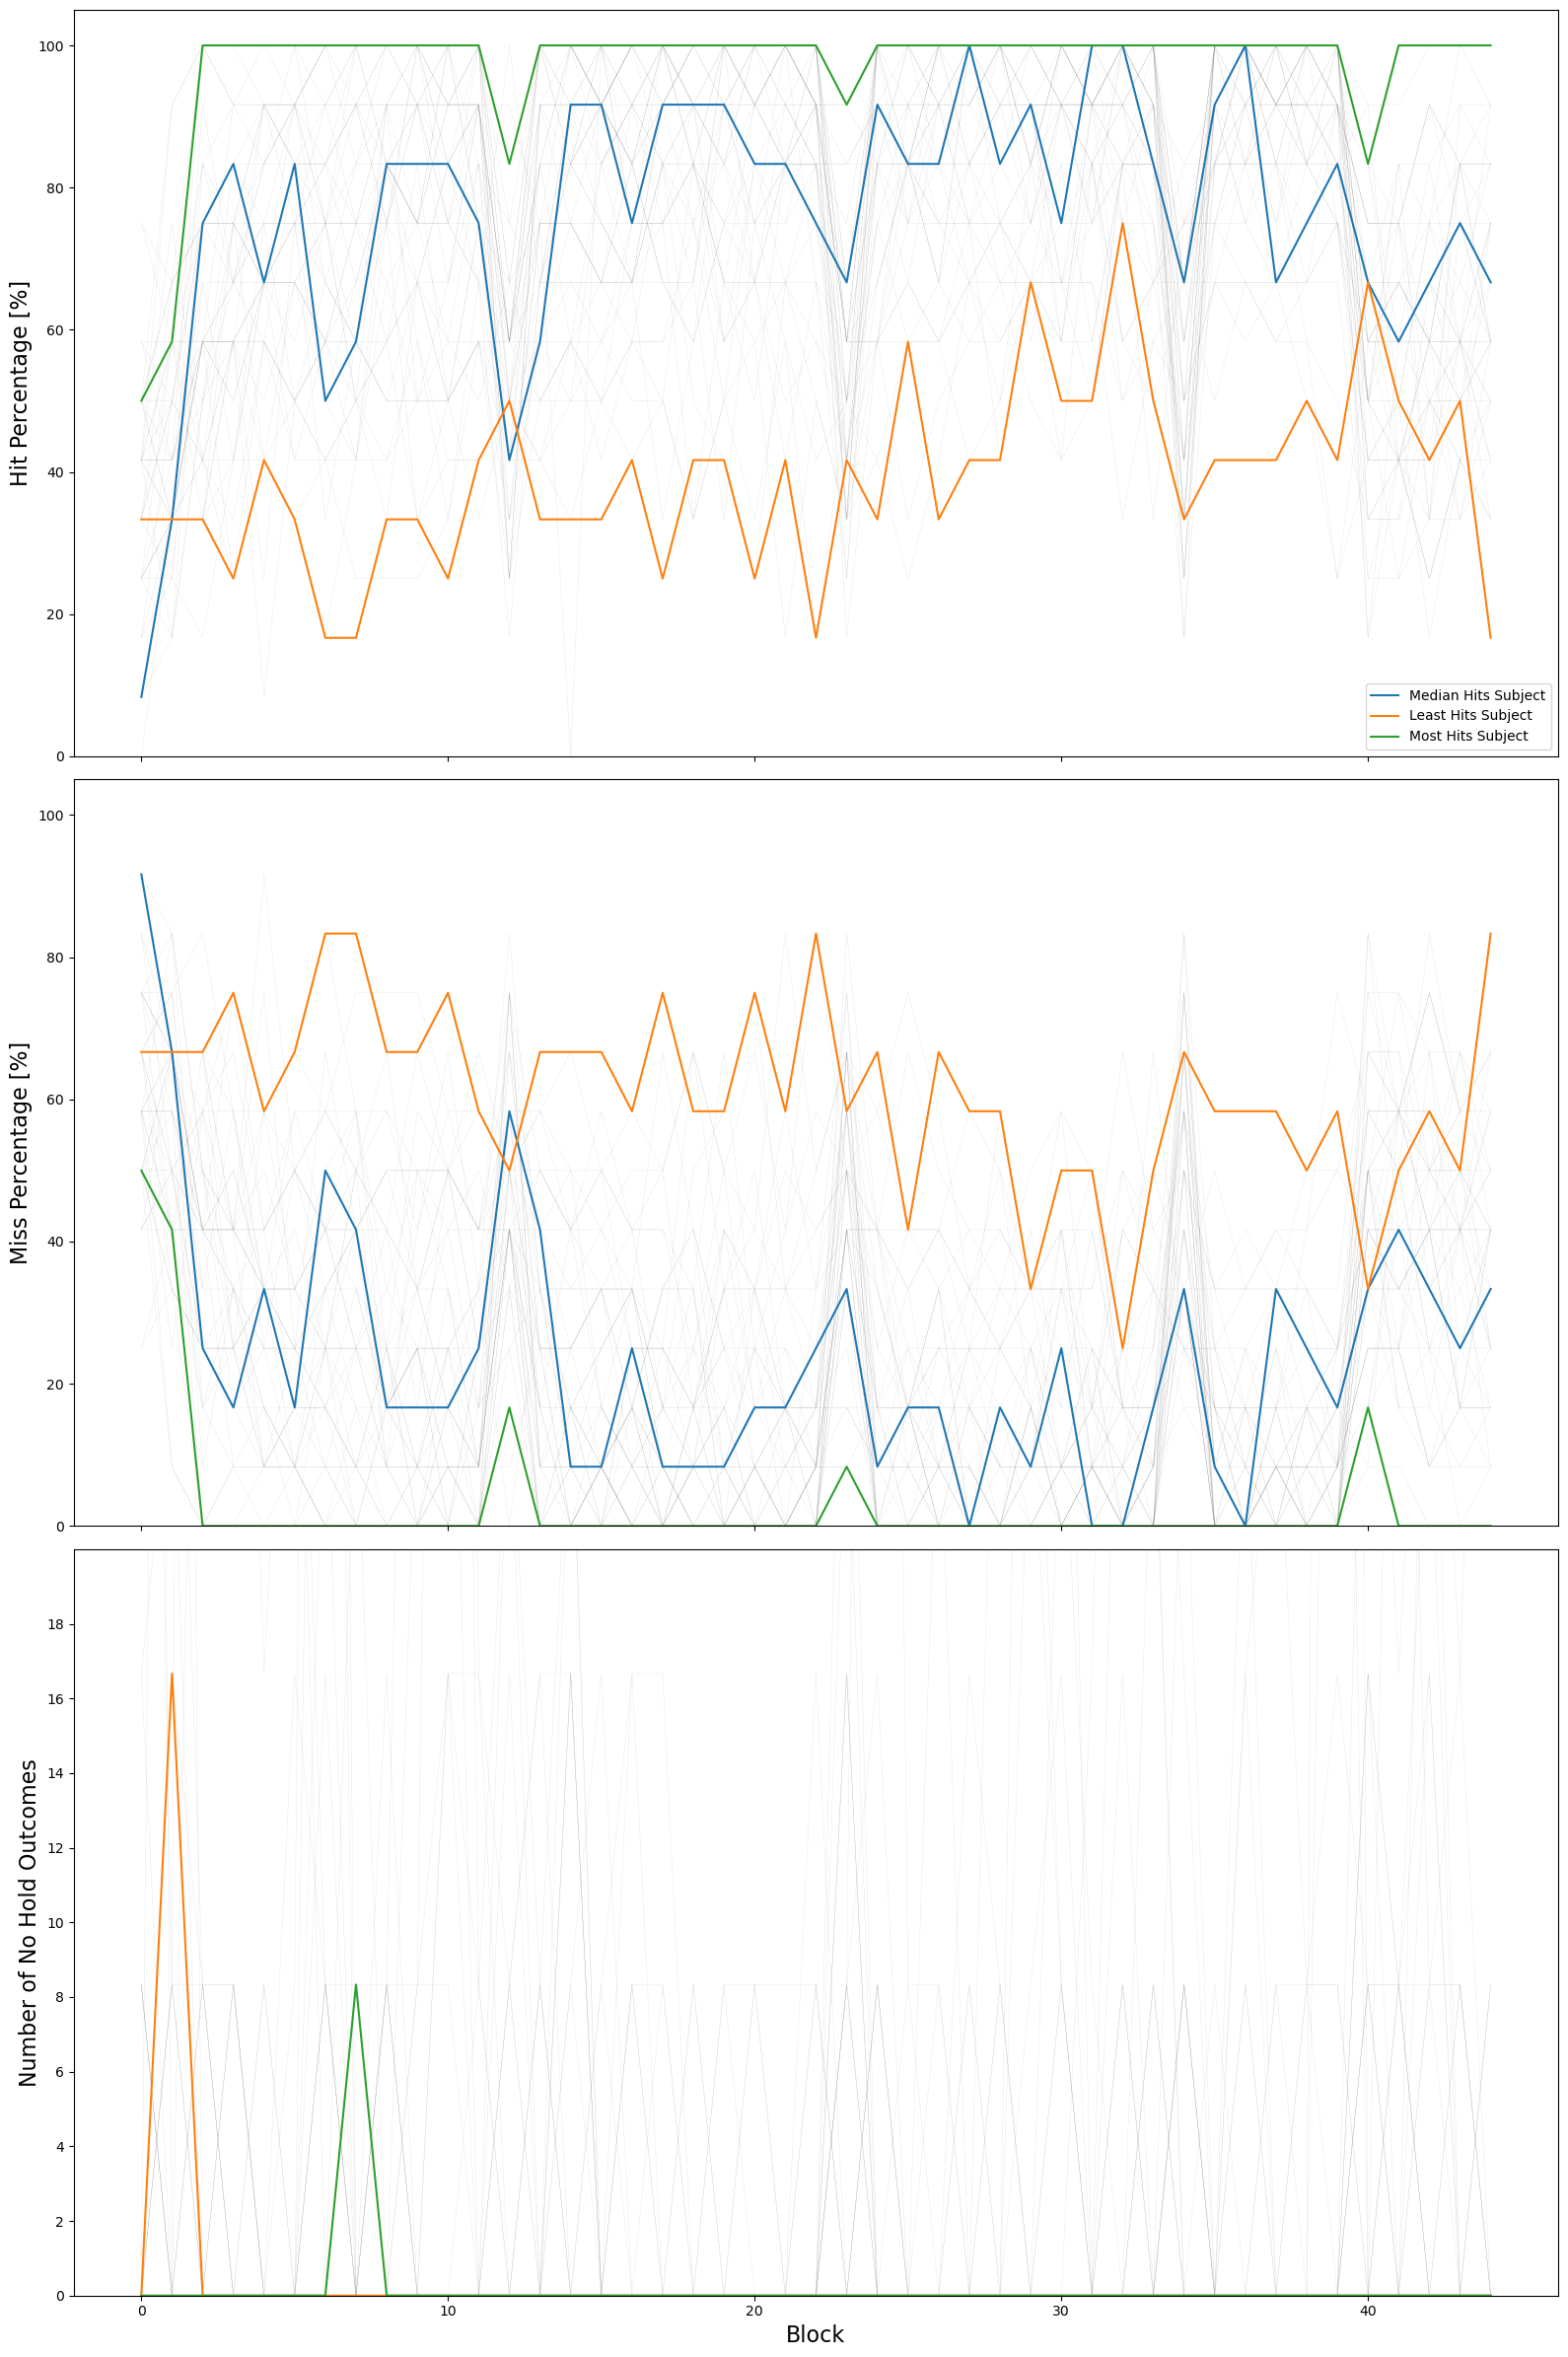

In [8]:
outcomes_fig, (hit_ax, miss_ax, nohold_ax) = plt.subplots(3,1,figsize=(16,24),sharex=True)

for sub in counts.keys():
    if sub == most_hit_subject:
        hit_ax.plot([h["hits"]/12*100 for h in counts[sub]][:45],label="Most Hits Subject",zorder=100)
        miss_ax.plot([h["misses"]/12*100 for h in counts[sub]][:45],zorder=100)
        nohold_ax.plot([h["noholds"]/12*100 for h in counts[sub]][:45],zorder=100)
    elif sub == median_hit_subject:
        hit_ax.plot([h["hits"]/12*100 for h in counts[sub]][:45],label="Median Hits Subject",zorder=100)
        miss_ax.plot([h["misses"]/12*100 for h in counts[sub]][:45],zorder=100)
        nohold_ax.plot([h["noholds"]/12*100 for h in counts[sub]][:45],zorder=100)
    elif sub == least_hit_subject:
        hit_ax.plot([h["hits"]/12*100 for h in counts[sub]][:45],label="Least Hits Subject",zorder=100)
        miss_ax.plot([h["misses"]/12*100 for h in counts[sub]][:45],zorder=100)
        nohold_ax.plot([h["noholds"]/12*100 for h in counts[sub]][:45],zorder=100)
    else:
        hit_ax.plot([h["hits"]/12*100 for h in counts[sub]][:45], "grey", linewidth=0.3,alpha=0.2)
        miss_ax.plot([h["misses"]/12*100 for h in counts[sub]][:45], "grey", linewidth=0.3,alpha=0.2)
        nohold_ax.plot([h["noholds"]/12*100 for h in counts[sub]][:45], "grey", linewidth=0.3,alpha=0.2)

# hit_ax.set_title("Hits over Blocks", fontsize=16)
hit_ax.set_ylim([0,105])
hit_ax.set_ylabel("Hit Percentage [%]", fontsize=16)
hit_ax.legend(loc="lower right")

# miss_ax.set_title("Misses over Blocks", fontsize=16)
miss_ax.set_ylim([0,105])
miss_ax.set_ylabel("Miss Percentage [%]", fontsize=16)

# nohold_ax.set_title("No Holds over Blocks", fontsize=16)
nohold_ax.set_ylabel("Number of No Hold Outcomes", fontsize=16)
nohold_ax.set_ylim([0,20])
nohold_ax.set_yticks(list(range(0,20,2)))
nohold_ax.set_xlabel("Block", fontsize=16)

outcomes_fig.tight_layout()

In [ ]:
outcomes_fig.savefig("/Users/spencer/motor-control/thesis/images/data_analysis2023/outcomes.pdf", dpi=300, format="pdf")

## hit percentages per target

In [77]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

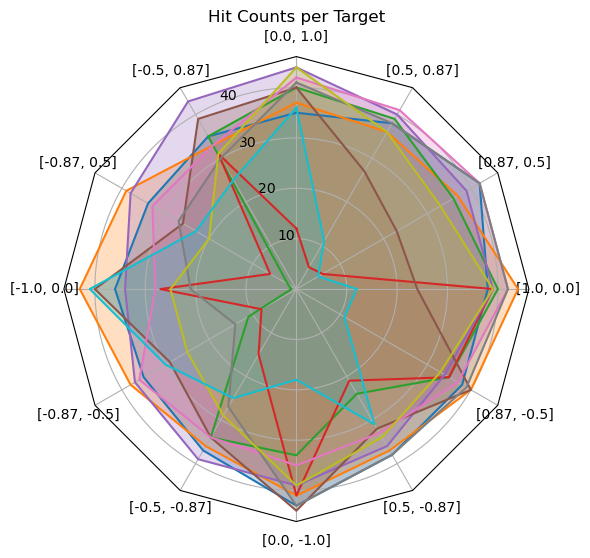

In [142]:
data = []
for subject in c.alphabetically_sorted_subjects():
    sessions  = subject.tasks["center_hold"].sorted_sessions()
    hit_counts_per_target = {}
    for sesh in sessions:
        trials = sesh.sorted_trials()
        for trial in trials:
            # get outcome
            oc = trial.outcome
            if oc == "Hit":
                # get target location
                try:
                    current_count = hit_counts_per_target[str(trial.target_coords)][1]
                    hit_counts_per_target[str(trial.target_coords)] = (trial.target_coords, current_count+1)
                except KeyError:
                    hit_counts_per_target[str(trial.target_coords)] = (trial.target_coords, 0)
    target_names = []
    counts = []
    # sort by theta angle
    for name, (coord, count) in sorted(hit_counts_per_target.items(), key=lambda s: np.arctan2(s[1][0][1],s[1][0][0])):
        target_names.append(name)
        counts.append(count)
    data.append(counts)


N = len(target_names)
theta = radar_factory(N, frame='polygon')

# roll these around to line up with plot coordinates
rollby=-8
spoke_labels = np.roll(np.array(target_names), rollby)
title = "Hit Counts per Target"

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([10, 20, 30, 40, 50, 60])
ax.set_title(title,  position=(0.5, 1.1), ha='center')

for d in data[-10:]:
    d = np.roll(np.array(d), rollby)
    line = ax.plot(theta, d)
    ax.fill(theta, d,  alpha=0.25)
ax.set_varlabels(spoke_labels)

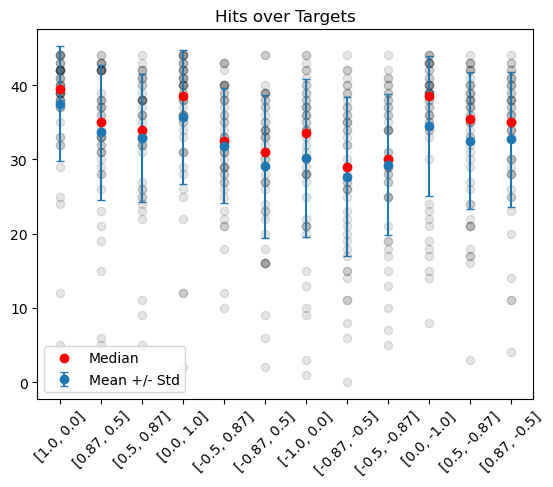

In [169]:
rollby = 7
fig, ax = plt.subplots(1,1)
for d in data:
    ax.plot(np.roll(d, rollby), 'ko', alpha=0.1)
ax.set_xticks(range(len(target_names)))
ax.set_xticklabels(np.roll(target_names, rollby), rotation=45)

means = np.mean(data,axis=0)
medians = np.median(data,axis=0)
stds = np.std(data,axis=0)
ax.errorbar(np.roll(target_names, rollby), np.roll(means, rollby), np.roll(stds, rollby), linestyle='None', marker='o', capsize=3, label="Mean +/- Std")
ax.plot(np.roll(target_names, rollby), np.roll(medians, rollby), 'ro', label="Median")
ax.set_title("Hits over Targets")
ax.legend()

## plot and fit the hit reach times

In [45]:
def avg(l):
    if len(l) == 0:
        return None
    else:
        return sum(l)/len(l)


def drop_nones(l, return_indices=False):
    new_l = []
    enum = []
    for i, e in enumerate(l):
        if not e is None:
            new_l.append(e)
            enum.append(i)
    if return_indices:
        return enum, new_l
    else:
        return new_l

In [46]:
# average "Hit" reach time per session over subjects
avg_reach_times = {}
for sub in c.subjects.values():
    avg_reach_times[sub.name] = []
    for session in sorted(list(sub.tasks["center_hold"].sessions.values()),key=lambda s: s.number):
        sorted_trials = sorted(list(session.trials.values()), key=lambda d: d.number)
        # mean hit reach time over trials in a session
        avg_reach_times[sub.name].append(avg([t.reach_time for t in sorted_trials if t.outcome == "Hit"]))

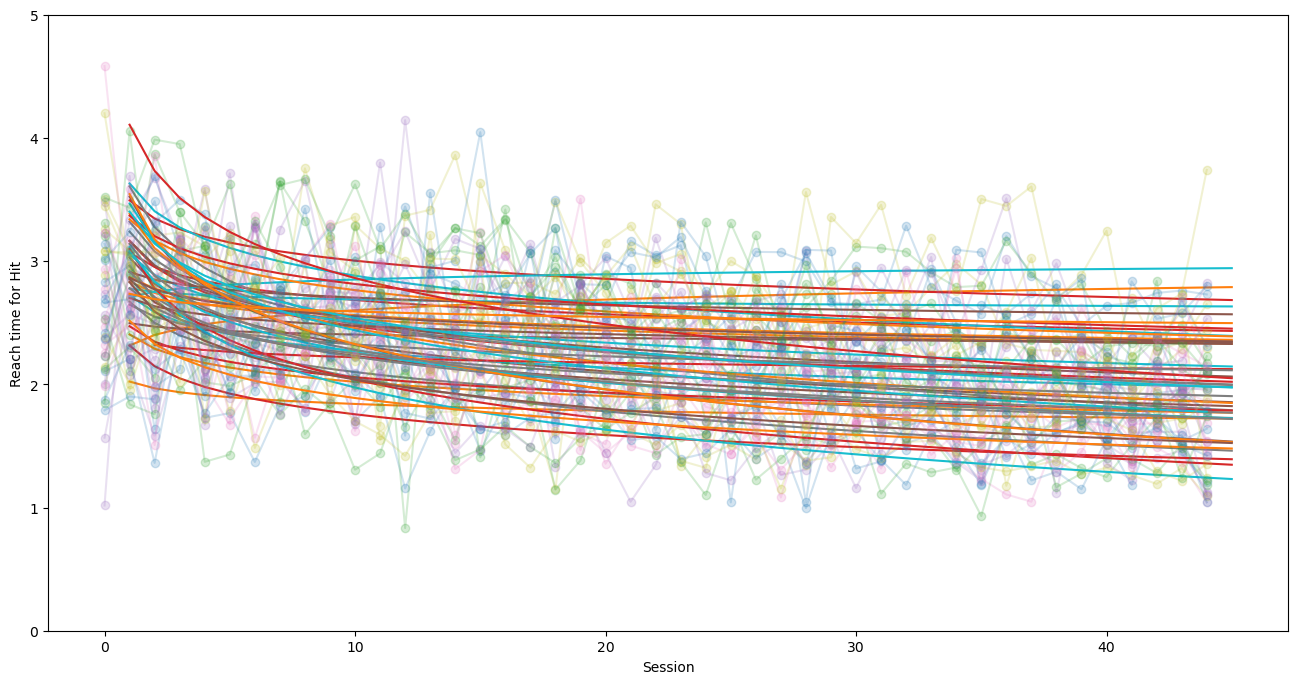

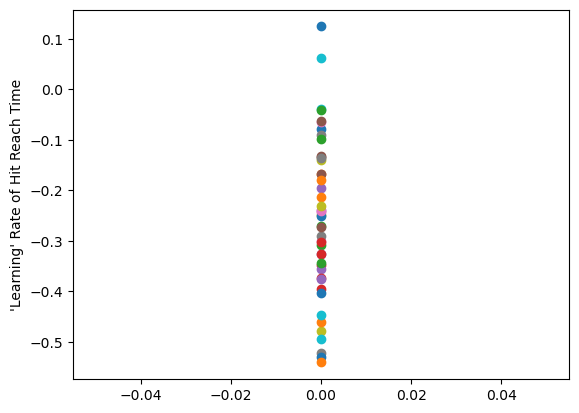

In [49]:
learning_rates = {}
fig, ax = plt.subplots(1,1, figsize=[16,8])
for s in c.subjects.values():
    t = avg_reach_times[s.name]
    x, y = drop_nones(t, return_indices=True)
    x = [xx+1 for xx in x]
    ax.plot(t,'o-',alpha=0.2)
    params = curve_fit(analysis.log, x, y)[0]
    ax.plot(x, analysis.log(x, params[0], params[1]))
    learning_rates[s.name] = params[1]
ax.set_ylim([0,5])
ax.set_ylabel("Reach time for Hit")
ax.set_xlabel("Session")

plt.figure()
for lr in list(learning_rates.values()):
    plt.plot(0,lr,'o')
    plt.ylabel("'Learning' Rate of Hit Reach Time")

# trajectory path length over trials

In [8]:
def path_length(a):
    assert a.shape[0] > a.shape[1], f"array with shape {a.shape} should be transposed."
    assert a.shape[1] == 2, f"array with shape {a.shape} must be two-dimensional"
    return np.sum(np.sqrt(np.sum(np.diff(a, axis=0)**2,axis=1)))

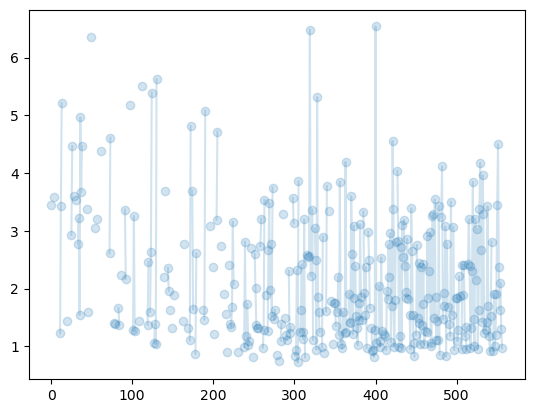

In [70]:
# 
sample_rate = 200 # samples / sec
reaction_time_delay = 50 # samples == 50 samples / 200Hz = 250ms 

# path lengths per trial over subjects
for sub in c.subjects.values():
    if sub.name == "alba":
        normalized_lengths = []
        # get sessions
        sorted_sessions = sorted(list(sub.tasks["center_hold"].sessions.values()),key= lambda s: s.number)
        for session in sorted_sessions:
            sorted_trials = sorted(list(session.trials.values()),key= lambda t: t.number)
            for t in sorted_trials:
                # only look at Hit trials
                if t.outcome == "Hit":
                    traj = t.get_trajectory()
                    # path length of movement time / reach time -- basically average velocity
                    normalized_lengths.append(path_length(traj[(int(np.ceil(t.hold_time*sample_rate)) + reaction_time_delay):,-2:]) / t.reach_time)
                else:
                    normalized_lengths.append(None)
        plt.plot(normalized_lengths,'o-',alpha=0.2)
        break

Seems like average velocity goes down over trials for hits! Interesting. 

# trajectory segments over trials

In [32]:
def get_zero_crossings(x):
    # find the indices where the velocity of the trajectory changes sign
    assert len(x.shape) == 1
    return np.where(np.diff(np.sign(np.diff(x))))[0]

def get_segment_indices(t, hold_steps, velocity_threshold_percentage=6, min_crossing_interval=8):
    assert t.shape[1] == 2, f"trajectory has incorrect shape: {t.shape}"
    zero_crosses_x = get_zero_crossings(t[:,0])
    zero_crosses_y = get_zero_crossings(t[:,1])
    # combine vx and vy together
    zero_crosses_xy = np.concatenate((zero_crosses_x, zero_crosses_y))
    # sort the x and y indices
    zero_crosses_xy.sort()
    zc_clean = []
    vel_lim = np.max(np.abs(t))*(velocity_threshold_percentage/100)
    for i, z in enumerate(zero_crosses_xy[:-1]):
        # ignore anything before hold period
        if z > hold_steps:
            # reject crossing if the neighborhood is low velocity
            if np.max(np.abs(t[z-min([5,z]):z+5, :])) > vel_lim:
                # reject the crossing if it's not spaced out above a threshold
                if abs(z - zero_crosses_xy[i+1]) > min_crossing_interval: 
                    zc_clean.append(z)
    return zc_clean

def sorted_dict_items_by_key(d):
    return [(k, v) for k, v in sorted(d.items(), key= lambda b: b[0])]

d = {"1":"blah", "4":"foo", "-4": "bar"}
sorted_dict_items_by_key(d)

[('-4', 'bar'), ('1', 'blah'), ('4', 'foo')]

In [58]:
reaction_time_delay = 50 # 200 ms?
sample_rate = 200

session_num = 9
trial_num = 3
# hold_time is the time until the target appears (subjects have thus held for 0.75s within a possible 3.5s window)
num_segments = {}
# get sorted subjects
subjects = sorted(list(c.subjects.values()), key= lambda s: s.name)
for subject in subjects:
    # get sorted sessions
    # fig, axes = plt.subplots(2,1,figsize=(16,12))
    segment_counts_per_trial = []
    sessions = sorted(list(subject.tasks["center_hold"].sessions.values()), key=lambda s: s.number)
    for session in sessions:
        # get sorted trials
        trials = sorted(list(session.trials.values()), key=lambda t: t.number)
        for trial in trials:
            # ignore no hold trials
            if trial.outcome == "Hit":
                trajectory = trial.get_trajectory()[:,-2:]
                hold_steps = int(np.ceil(trial.hold_time*sample_rate)) + reaction_time_delay
                # find segments
                segment_indices = get_segment_indices(trajectory, hold_steps=hold_steps)
                # test plot
                # axes[0].plot(range(hold_steps), trajectory[:hold_steps,0], "b")
                # axes[0].plot(range(hold_steps, trajectory.shape[0]), trajectory[hold_steps:,0], "r")
                # axes[0].plot(range(hold_steps), trajectory[:hold_steps,1], "b")
                # axes[0].plot(range(hold_steps, trajectory.shape[0]), trajectory[hold_steps:,1], "r")
                # axes[0].plot(segment_indices, trajectory[segment_indices,0], "go",markersize=5)
                # axes[0].plot(segment_indices, trajectory[segment_indices,1], "go",markersize=5)

                # color = "b"
                # for i, zc in enumerate(segment_indices[:-1]):
                #     if color == "r":
                #         color = "b"
                #     else:
                #         color = "r"
                #     axes[1].plot(trajectory[:,0],trajectory[:,1],"k", alpha=0.2)
                #     axes[1].plot(trajectory[zc:segment_indices[i+1]+1,0],trajectory[zc:segment_indices[i+1]+1,1], color)
                #     axes[1].plot(trajectory[segment_indices,0], trajectory[segment_indices,1], "ko", markersize=3)
                segment_counts_per_trial.append(len(segment_indices))
            elif trial.outcome == "Miss":
                segment_counts_per_trial.append(None)
    num_segments[subject.name] = segment_counts_per_trial

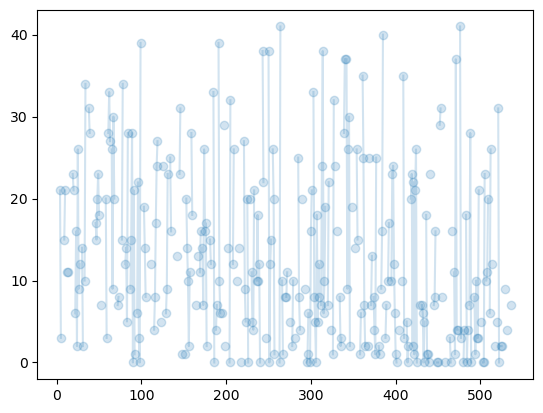

In [66]:
fig, axes = plt.subplots(1,1)
for subject_name, counts in list(num_segments.items())[2:3]:
    plt.plot(counts, "o-", alpha=0.2)

Seems like by eye there's not much of a trend here. But we can use the segment analysis to understand "corrections" with some work.